## Setting Up

In [21]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
import zipfile as zf # handle zip files

# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [15,7]
plt.rcParams['font.size'] = 15




In [3]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from sklearn.metrics import r2_score

### Leitura

In [4]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh', title=''):
    """ Gráficos ACF, PACF, QQPLOT e de Probabilidades. """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

# remover tendência

def difference(dataset, interval=1) -> pd.Series:
    """ Funcao de diferenciacao: z(t) - z(t-inteval). """
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

In [75]:
# Loading files
unzip_fs = zf.ZipFile('competitive-data-science-predict-future-sales.zip', 'r')

aux = unzip_fs.open('sales_train.csv', 'r')
sales = pd.read_csv(aux)
aux.close()

# aux = unzip_fs.open('items.csv', 'r')
# item = pd.read_csv(aux)
# aux.close()


# Dont need to load
# aux = unzip_fs.open("item_categories.csv")
# item_cat=pd.read_csv(aux)
# aux.close()

# sub=pd.read_csv("sample_submission.csv")

# aux = unzip_fs.open("shops.csv")
# shops=pd.read_csv(aux)
# aux.close()

# aux = unzip_fs.open("test.csv")
# test=pd.read_csv(aux)
# aux.close()
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [76]:
# formatando a coluna 'data' das vendas:
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


### Soma

Obs de treino: 974 
Obs de teste: 60


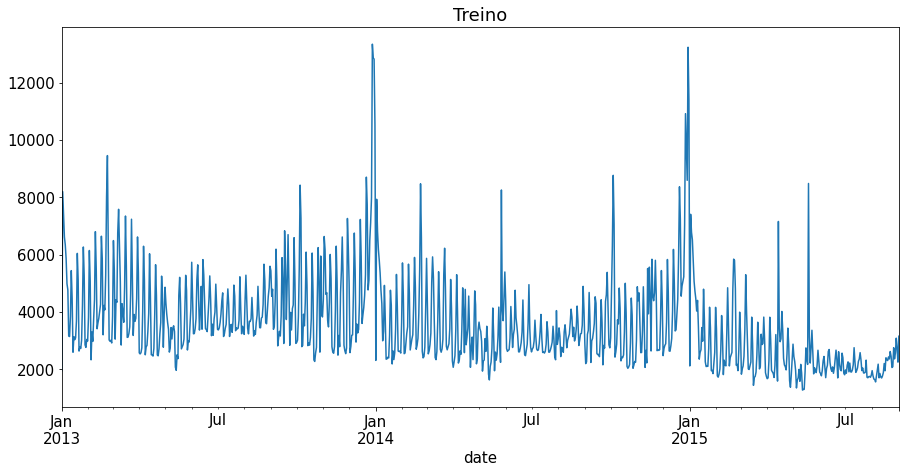

In [79]:
# agrupando todas as vendas da companhia
sales_sum =sales.groupby(by=['date'])["item_cnt_day"].sum()

# separando em conjunto de treino e validação
teste = sales_sum.iloc[974:]
treino = sales_sum.iloc[:-60]
print(f'Obs de treino: {treino.shape[0]} \nObs de teste: {teste.shape[0]}')
treino.plot().set_title("Treino");

In [81]:
arima_model =  auto_arima(treino,start_p=0, d=None, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=None, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=7, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=16700.520, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=16384.311, Time=0.70 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=16496.077, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=16698.522, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=16700.661, Time=0.17 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=16288.952, Time=1.54 sec
 ARIMA(1,1,0)(3,0,0)[7] intercept   : AIC=16237.345, Time=2.98 sec
 ARIMA(1,1,0)(4,0,0)[7] intercept   : AIC=16213.982, Time=4.05 sec
 ARIMA(1,1,0)(5,0,0)[7] intercept   : AIC=inf, Time=8.84 sec
 ARIMA(1,1,0)(4,0,1)[7] intercept   : AIC=16229.209, Time=8.47 sec
 ARIMA(1,1,0)(3,0,1)[7] intercept   : AIC=16244.925, Time=6.39 sec
 ARIMA(1,1,0)(5,0,1)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(4,0,0)[7] intercept   : AIC=16257.044, Time=3.31 sec
 ARIMA(2,1,0)(4,0,0)[7] intercept   : AIC=16154.720, Time=5.40 sec
 ARIMA(2,1,0)(3,0,0)[7] intercep

In [85]:
print(arima_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  974
Model:             SARIMAX(3, 1, 0)x(5, 0, [1], 7)   Log Likelihood               -8020.112
Date:                             Thu, 08 Dec 2022   AIC                          16060.225
Time:                                     19:47:02   BIC                          16109.028
Sample:                                 01-01-2013   HQIC                         16078.798
                                      - 09-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2849      0.018    -15.671      0.000      -0.321      -0.249
ar.L2         -0.2670      

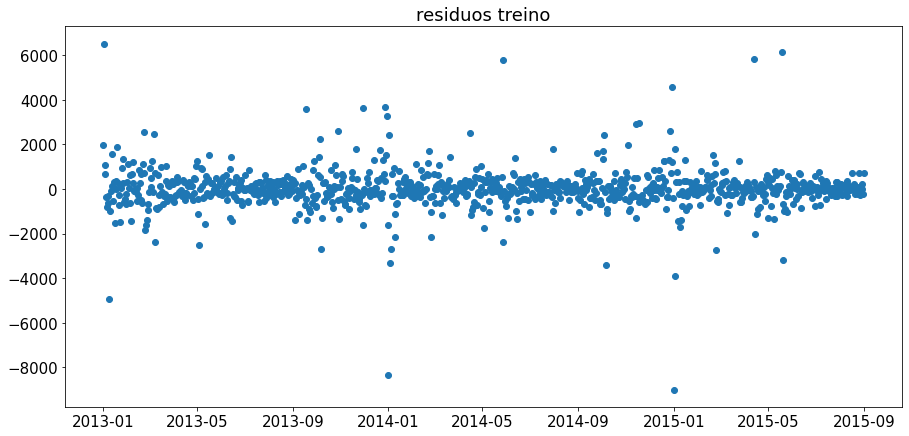

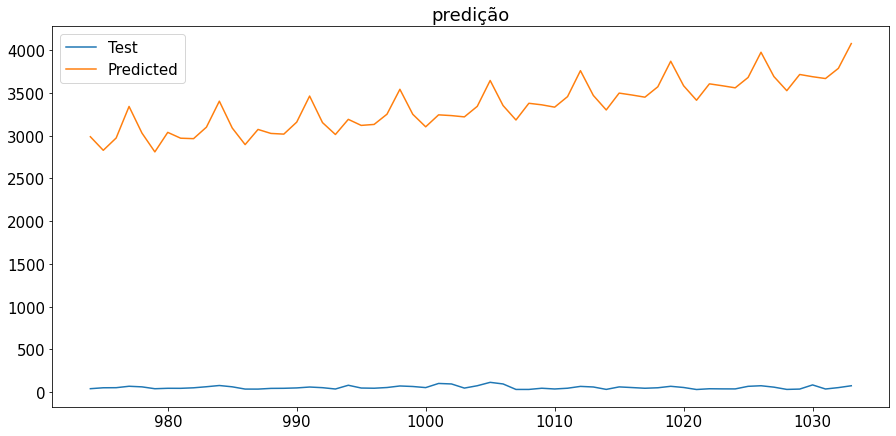

In [93]:
residuos = arima_model.resid()
predicao = pd.DataFrame(arima_model.predict(n_periods = 60)).set_index(teste.index)

plt.figure()
plt.scatter(x=residuos.index, y=residuos)
plt.title("residuos treino")
plt.plot()

plt.figure()
# plt.plot(treino,label="Training")
plt.plot(teste['item_cnt_day'],label="Test")
plt.plot(predicao,label="Predicted")
plt.title("predição")
plt.legend()
plt.show()

### Média

Obs de treino: 974 
Obs de teste: 60


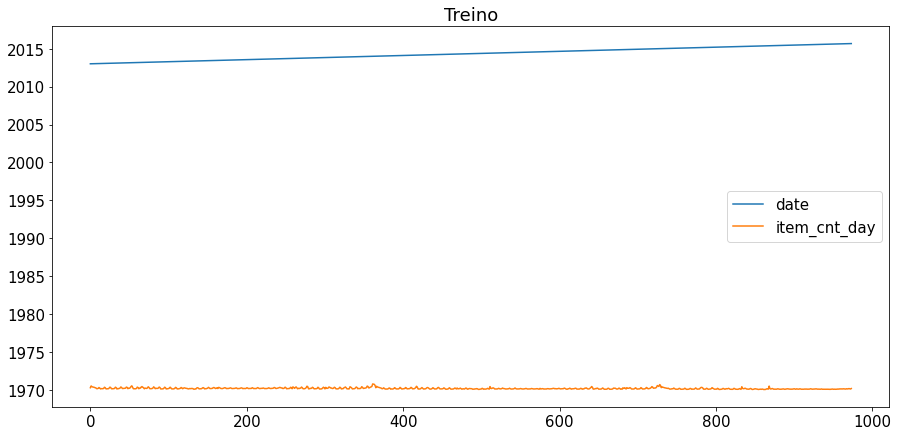

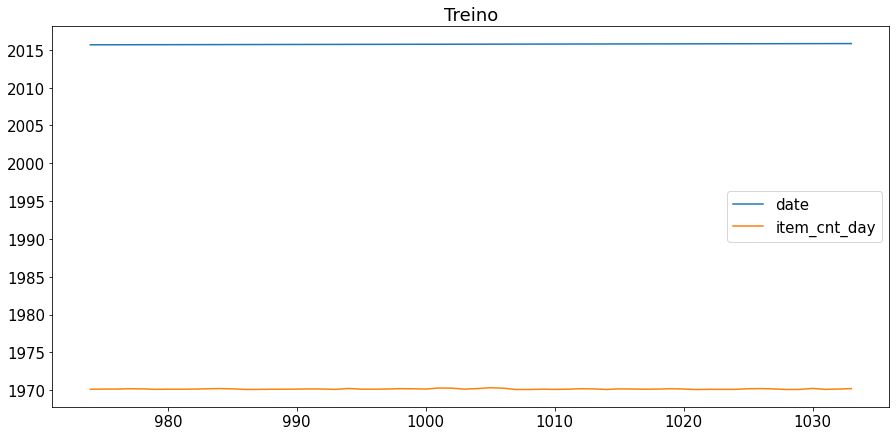

In [84]:
# agrupando todas as vendas da companhia
sales_shop = sales.groupby(by=['date',"shop_id"])[["item_cnt_day"]].sum().reset_index()
sales_mean = sales_shop.groupby(by=['date'])[["item_cnt_day"]].mean().reset_index()

# separando em conjunto de treino e validação
teste = sales_mean.iloc[974:]
treino = sales_mean.iloc[:-60]
print(f'Obs de treino: {treino.shape[0]} \nObs de teste: {teste.shape[0]}')
treino.plot().set_title("Treino")
plt.show()
teste.plot().set_title("Treino")
plt.show()

In [ ]:
arima_model =  auto_arima(treino,start_p=0, d=None, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=None, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=7, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=16700.520, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=16384.311, Time=0.70 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=16496.077, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=16698.522, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=16700.661, Time=0.17 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=16288.952, Time=1.54 sec
 ARIMA(1,1,0)(3,0,0)[7] intercept   : AIC=16237.345, Time=2.98 sec
 ARIMA(1,1,0)(4,0,0)[7] intercept   : AIC=16213.982, Time=4.05 sec
 ARIMA(1,1,0)(5,0,0)[7] intercept   : AIC=inf, Time=8.84 sec
 ARIMA(1,1,0)(4,0,1)[7] intercept   : AIC=16229.209, Time=8.47 sec
 ARIMA(1,1,0)(3,0,1)[7] intercept   : AIC=16244.925, Time=6.39 sec
 ARIMA(1,1,0)(5,0,1)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(4,0,0)[7] intercept   : AIC=16257.044, Time=3.31 sec
 ARIMA(2,1,0)(4,0,0)[7] intercept   : AIC=16154.720, Time=5.40 sec
 ARIMA(2,1,0)(3,0,0)[7] intercep

In [ ]:
print(arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  974
Model:             SARIMAX(1, 1, 1)x(5, 0, [], 7)   Log Likelihood               -8353.893
Date:                            Thu, 08 Dec 2022   AIC                          16723.786
Time:                                    19:33:57   BIC                          16762.829
Sample:                                         0   HQIC                         16738.645
                                            - 974                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4268      0.022     19.510      0.000       0.384       0.470
ma.L1         -0.9886      0.005   

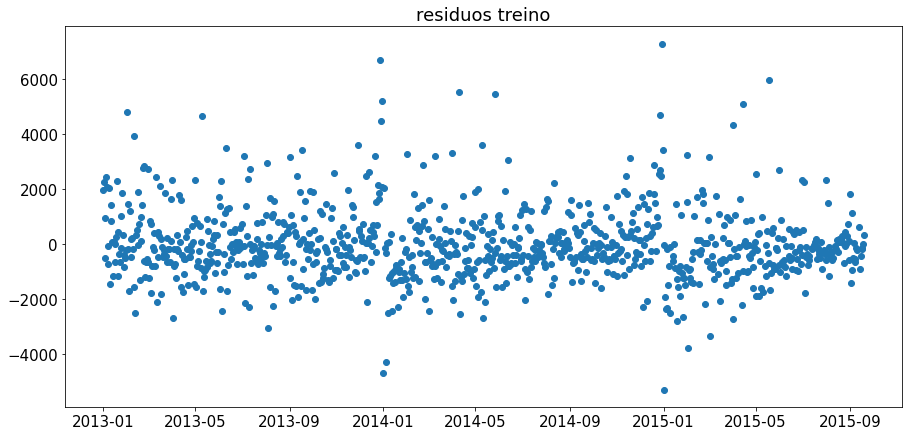

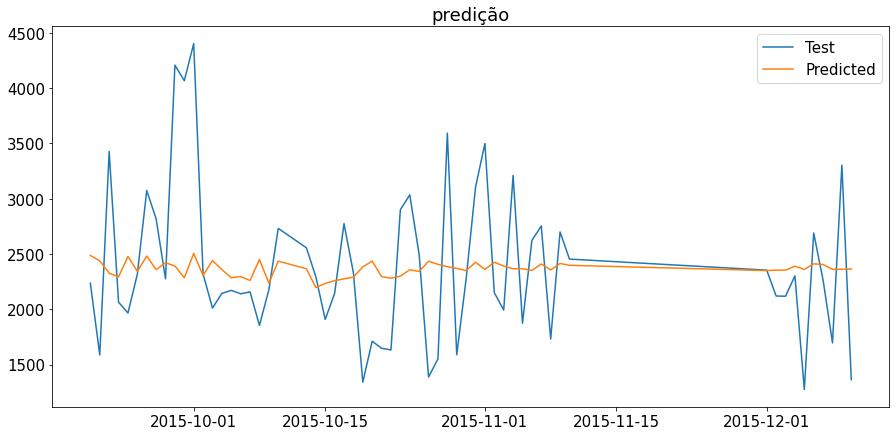

In [ ]:
residuos = arima_model.resid()
predicao = pd.DataFrame(arima_model.predict(n_periods = 60)).set_index(teste.index)

plt.figure()
plt.scatter(x=residuos.index, y=residuos)
plt.title("residuos treino")
plt.plot()

plt.figure()
# plt.plot(treino,label="Training")
plt.plot(teste,label="Test")
plt.plot(predicao,label="Predicted")
plt.title("predição")
plt.legend()
plt.show()